<a href="https://colab.research.google.com/github/ccyyyYyzz/GI_GAN/blob/main/GI_GAN_learning_code_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


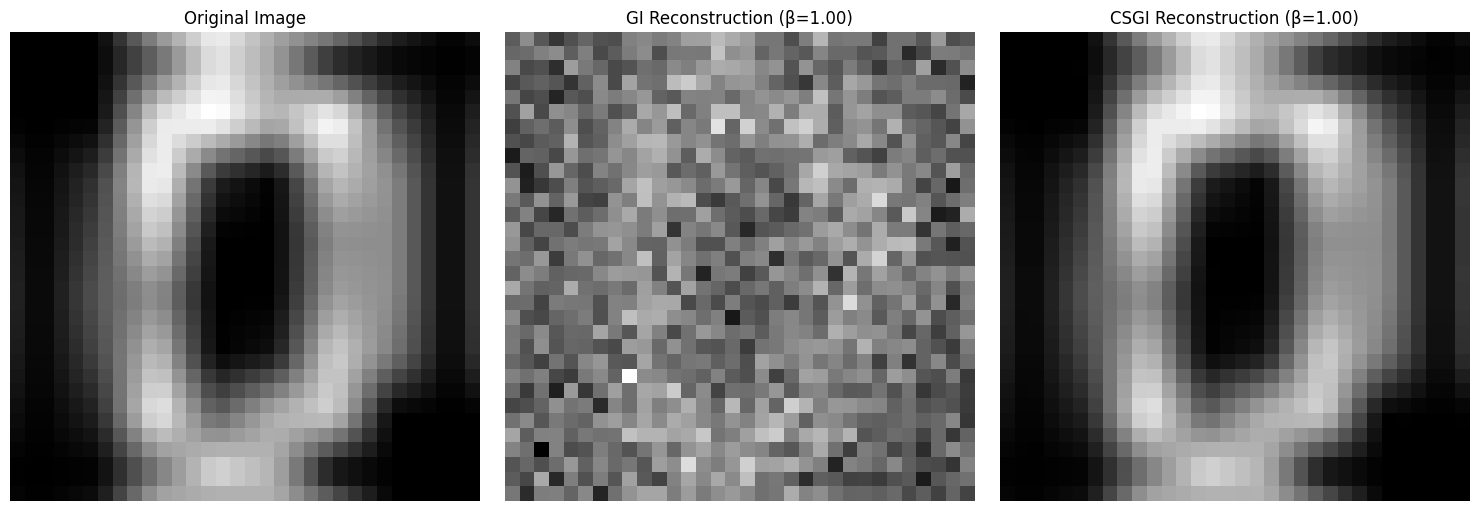

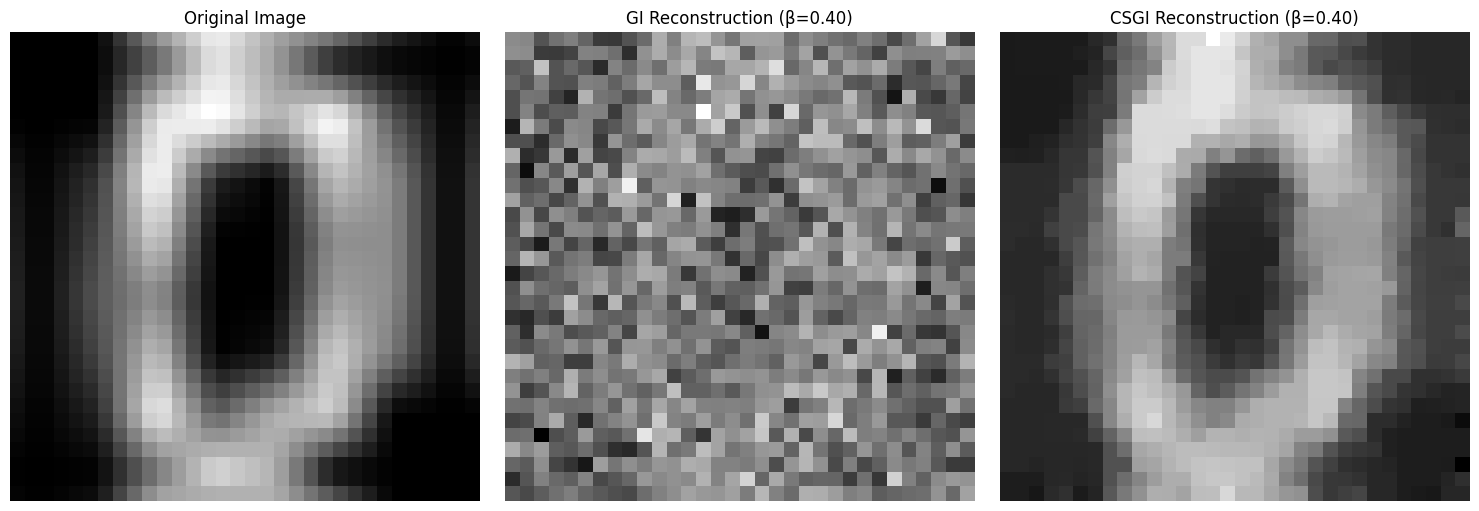

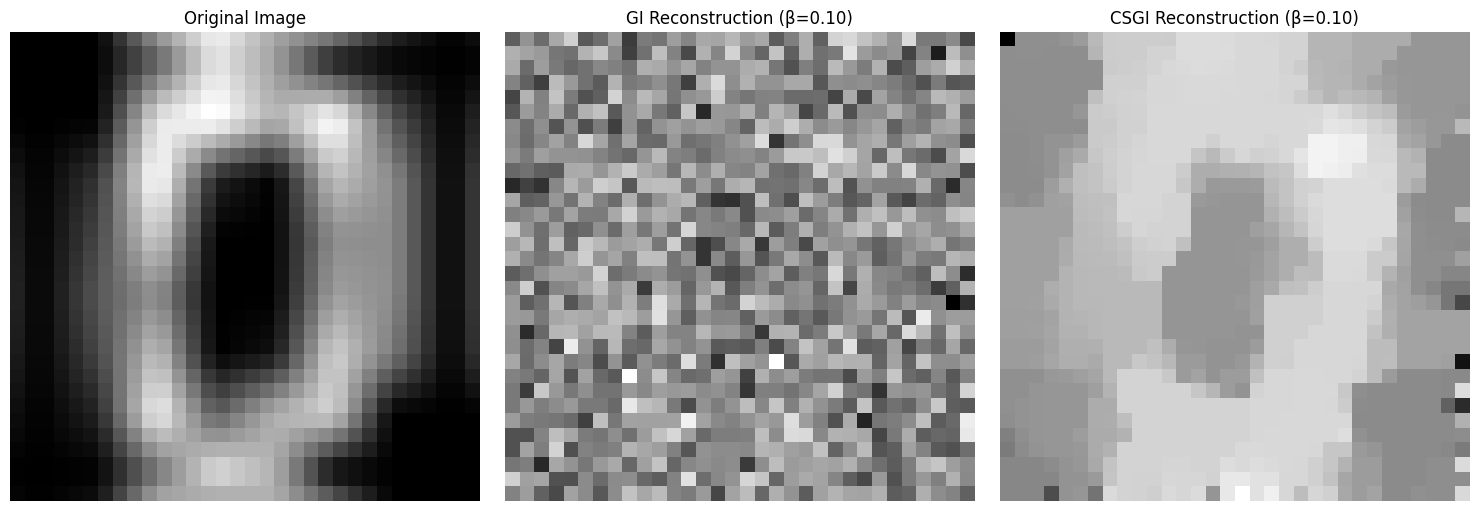

In [ ]:
#original figure, GI, CSGI (different beta)
# # 预处理第一版
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import cvxpy as cp
from skimage.restoration import denoise_tv_chambolle

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install cvxpy scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 数据准备

def prepare_data(image_size=32):
    # 加载MNIST数据集
    digits = load_digits()

    # 选择一个数字图像并调整大小
    image = digits.images[0]
    image = resize(image, (image_size, image_size), anti_aliasing=True)

    return image

# 生成随机speckle模式
def generate_speckle_patterns(num_patterns, image_size):
    return np.random.rand(num_patterns, image_size, image_size)

# 计算bucket信号
def calculate_bucket_signal(image, speckle_patterns):
    return np.sum(image * speckle_patterns, axis=(1, 2))

# 传统鬼影成像重构
def gi_reconstruction(bucket_signal, speckle_patterns):
    mean_bucket = np.mean(bucket_signal)
    mean_speckle = np.mean(speckle_patterns, axis=0)

    delta_bucket = bucket_signal - mean_bucket
    delta_speckle = speckle_patterns - mean_speckle

    reconstruction = np.mean(delta_bucket[:, np.newaxis, np.newaxis] * delta_speckle, axis=0)
    return reconstruction

# 压缩感知鬼影成像重构
def csgi_reconstruction(bucket_signal, speckle_patterns, lambda_tv):
    image_size = speckle_patterns.shape[1]
    num_patterns = speckle_patterns.shape[0]

    # 将speckle模式展平为矩阵A
    A = speckle_patterns.reshape(num_patterns, -1)

    # 定义优化问题
    x = cp.Variable(image_size * image_size)
    objective = cp.Minimize(cp.sum_squares(A @ x - bucket_signal) + lambda_tv * cp.tv(cp.reshape(x, (image_size, image_size))))
    prob = cp.Problem(objective)

    # 求解优化问题
    prob.solve()

    # 重塑结果为图像
    reconstruction = x.value.reshape(image_size, image_size)
    return reconstruction

# 可视化结果
def visualize_results(original, gi_recon, csgi_recon, sampling_rate):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(gi_recon, cmap='gray')
    axes[1].set_title(f'GI Reconstruction (β={sampling_rate:.2f})')
    axes[2].imshow(csgi_recon, cmap='gray')
    axes[2].set_title(f'CSGI Reconstruction (β={sampling_rate:.2f})')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 主函数
def main():
    image_size = 32
    original_image = prepare_data(image_size)

    sampling_rates = [1.0, 0.4, 0.1]

    for beta in sampling_rates:
        num_patterns = int(beta * image_size * image_size)
        speckle_patterns = generate_speckle_patterns(num_patterns, image_size)

        # 计算bucket信号
        bucket_signal = calculate_bucket_signal(original_image, speckle_patterns)

        # 传统GI重构
        gi_recon = gi_reconstruction(bucket_signal, speckle_patterns)

        # CSGI重构
        lambda_tv = 0.1  # 可以调整这个参数以获得更好的结果
        csgi_recon = csgi_reconstruction(bucket_signal, speckle_patterns, lambda_tv)

        # 可视化结果
        visualize_results(original_image, gi_recon, csgi_recon, beta)

if __name__ == "__main__":
    main()


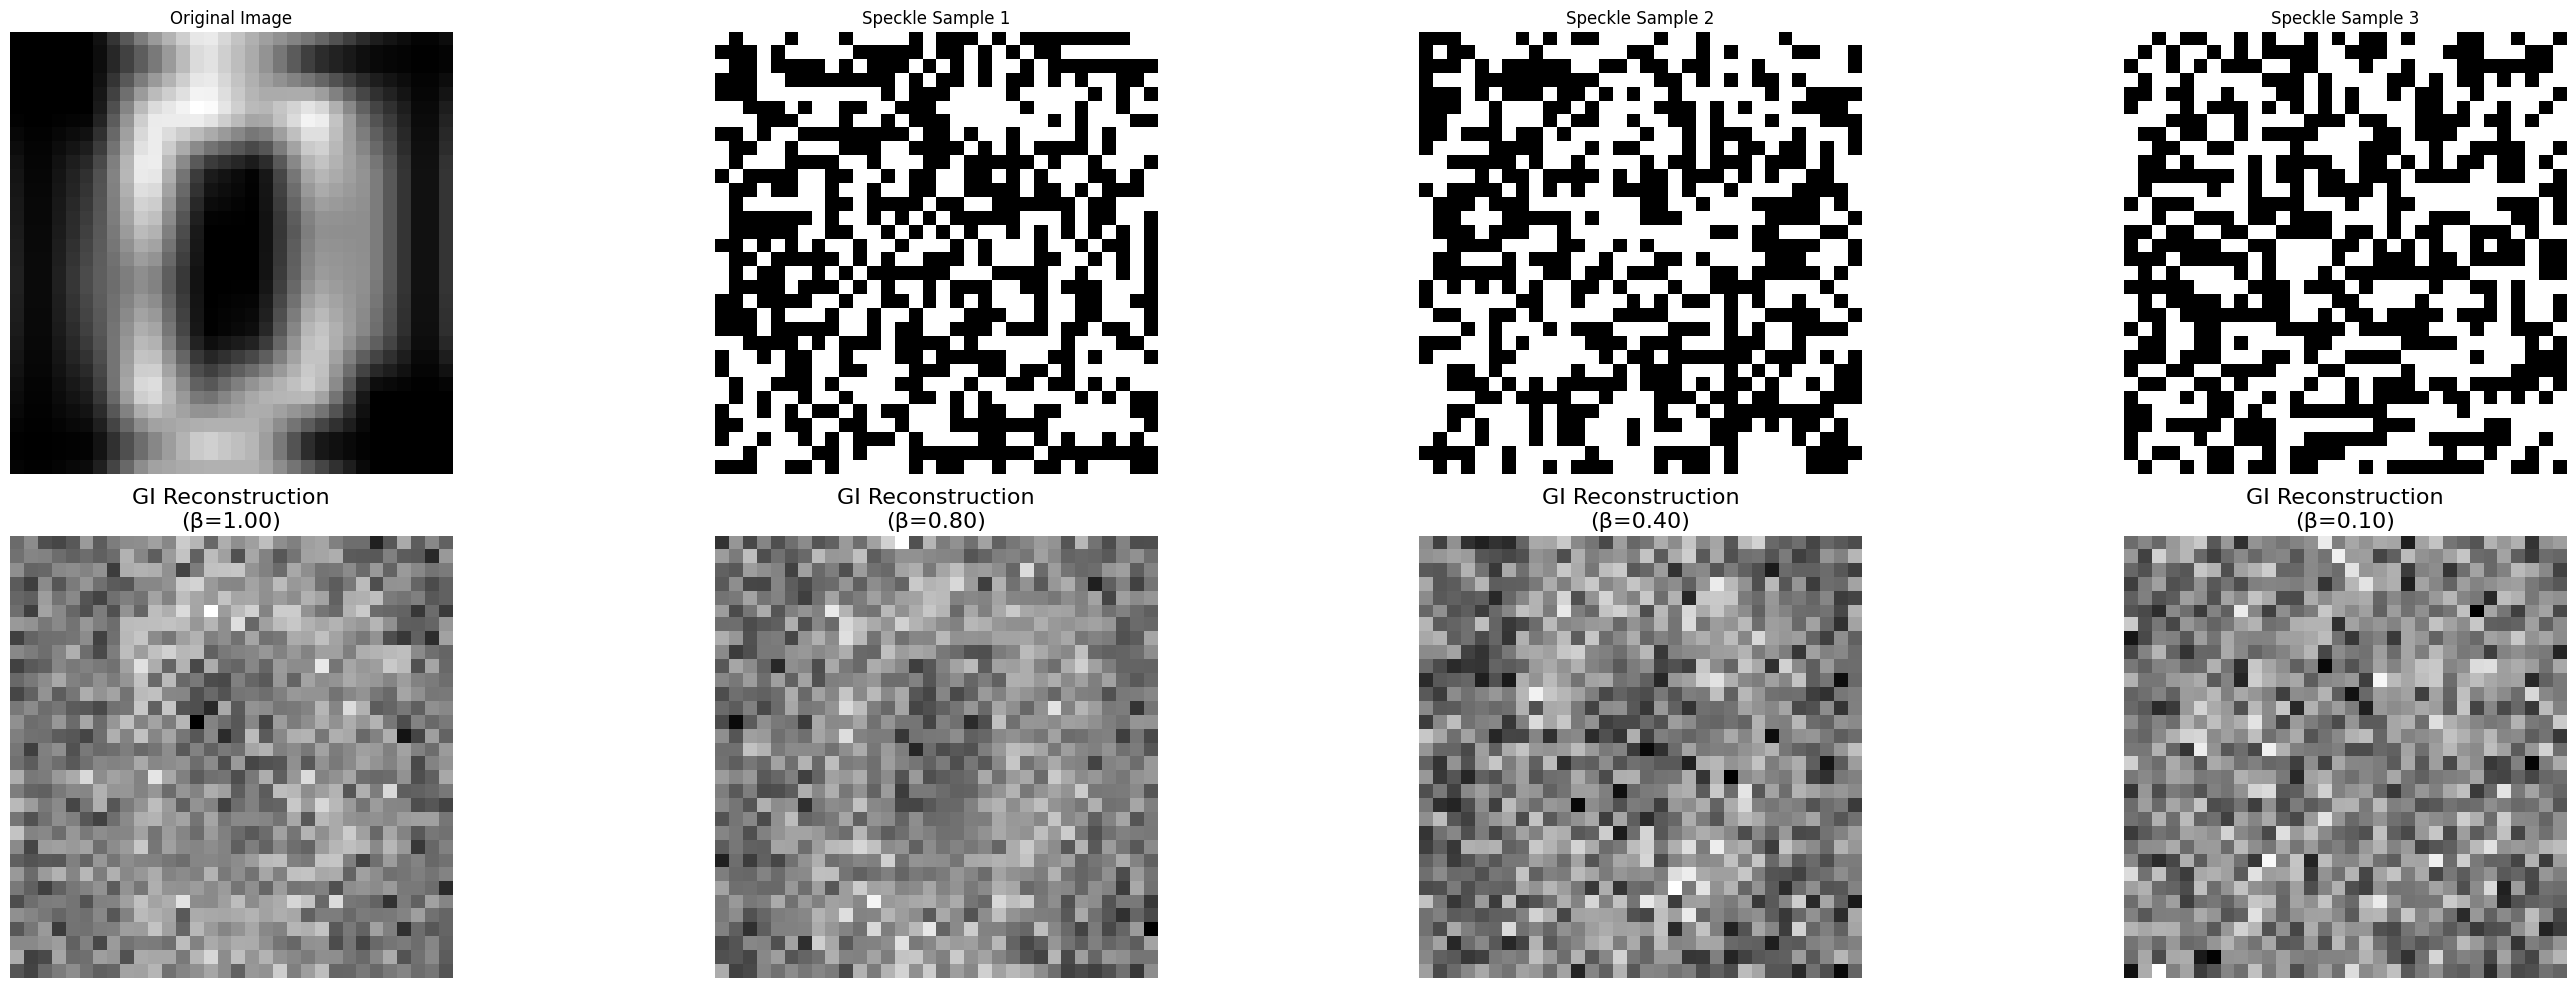

In [ ]:
# 预处理第二版
# 这个和第一个mmodule差不多，但改了一下，可视化了一下散斑
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 数据准备
def prepare_data(image_size=32):
    """
    从MNIST数据集加载并预处理手写数字图像
    """
    # 加载MNIST数据集
    digits = load_digits()
    # 选择一个数字图像并调整大小
    image = digits.images[0]
    image = resize(image, (image_size, image_size), anti_aliasing=True)
    # 归一化图像到0-1范围
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

# 生成随机speckle模式
def generate_speckle_patterns(num_patterns, image_size):
    """
    生成随机的二值speckle光斑模式
    """
    return np.random.randint(0, 2, (num_patterns, image_size, image_size))

# 计算bucket信号
def calculate_bucket_signal(image, speckle_patterns):
    """
    计算每个speckle模式对目标图像的积分
    """
    return np.sum(image * speckle_patterns, axis=(1, 2))

# 传统鬼影成像重构
def gi_reconstruction(bucket_signal, speckle_patterns):
    """
    使用传统GI方法重构图像
    """
    mean_bucket = np.mean(bucket_signal)
    mean_speckle = np.mean(speckle_patterns, axis=0)
    delta_bucket = bucket_signal - mean_bucket
    delta_speckle = speckle_patterns - mean_speckle
    reconstruction = np.mean(delta_bucket[:, np.newaxis, np.newaxis] * delta_speckle, axis=0)
    return reconstruction

# 可视化结果
def visualize_results(original, speckle_samples, reconstructions, sampling_rates):
    """
    可视化原始图像、speckle样本和重构结果
    """
    num_rates = len(sampling_rates)
    fig, axes = plt.subplots(2, num_rates, figsize=(5 * (num_rates + 2), 10))

    # 显示原始图像
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # 显示speckle样本
    for i in range(3):
        axes[0, i+1].imshow(speckle_samples[i], cmap='binary')
        axes[0, i+1].set_title(f'Speckle Sample {i+1}')
        axes[0, i+1].axis('off')

    for i, (beta, recon) in enumerate(zip(sampling_rates, reconstructions)):
        # 归一化重构结果到0-1范围
        recon_norm = (recon - np.min(recon)) / (np.max(recon) - np.min(recon))
        axes[1, i].imshow(recon_norm, cmap='gray')
        axes[1, i].set_title(f'GI Reconstruction\n(β={beta:.2f})', fontsize=16)
        axes[1, i].axis('off')

    plt.tight_layout(pad=1.0)  # 增加子图之间的间距
    plt.show()

# 主函数
def main():
    image_size = 32
    original_image = prepare_data(image_size)
    sampling_rates = [1.0, 0.8, 0.4, 0.1]
    reconstructions = []

    # 生成一些speckle样本用于可视化
    speckle_samples = generate_speckle_patterns(3, image_size)

    for beta in sampling_rates:
        num_patterns = int(beta * image_size * image_size)
        speckle_patterns = generate_speckle_patterns(num_patterns, image_size)

        # 计算bucket信号
        bucket_signal = calculate_bucket_signal(original_image, speckle_patterns)

        # 传统GI重构
        gi_recon = gi_reconstruction(bucket_signal, speckle_patterns)
        reconstructions.append(gi_recon)

    # 可视化结果
    visualize_results(original_image, speckle_samples, reconstructions, sampling_rates)

if __name__ == "__main__":
    main()


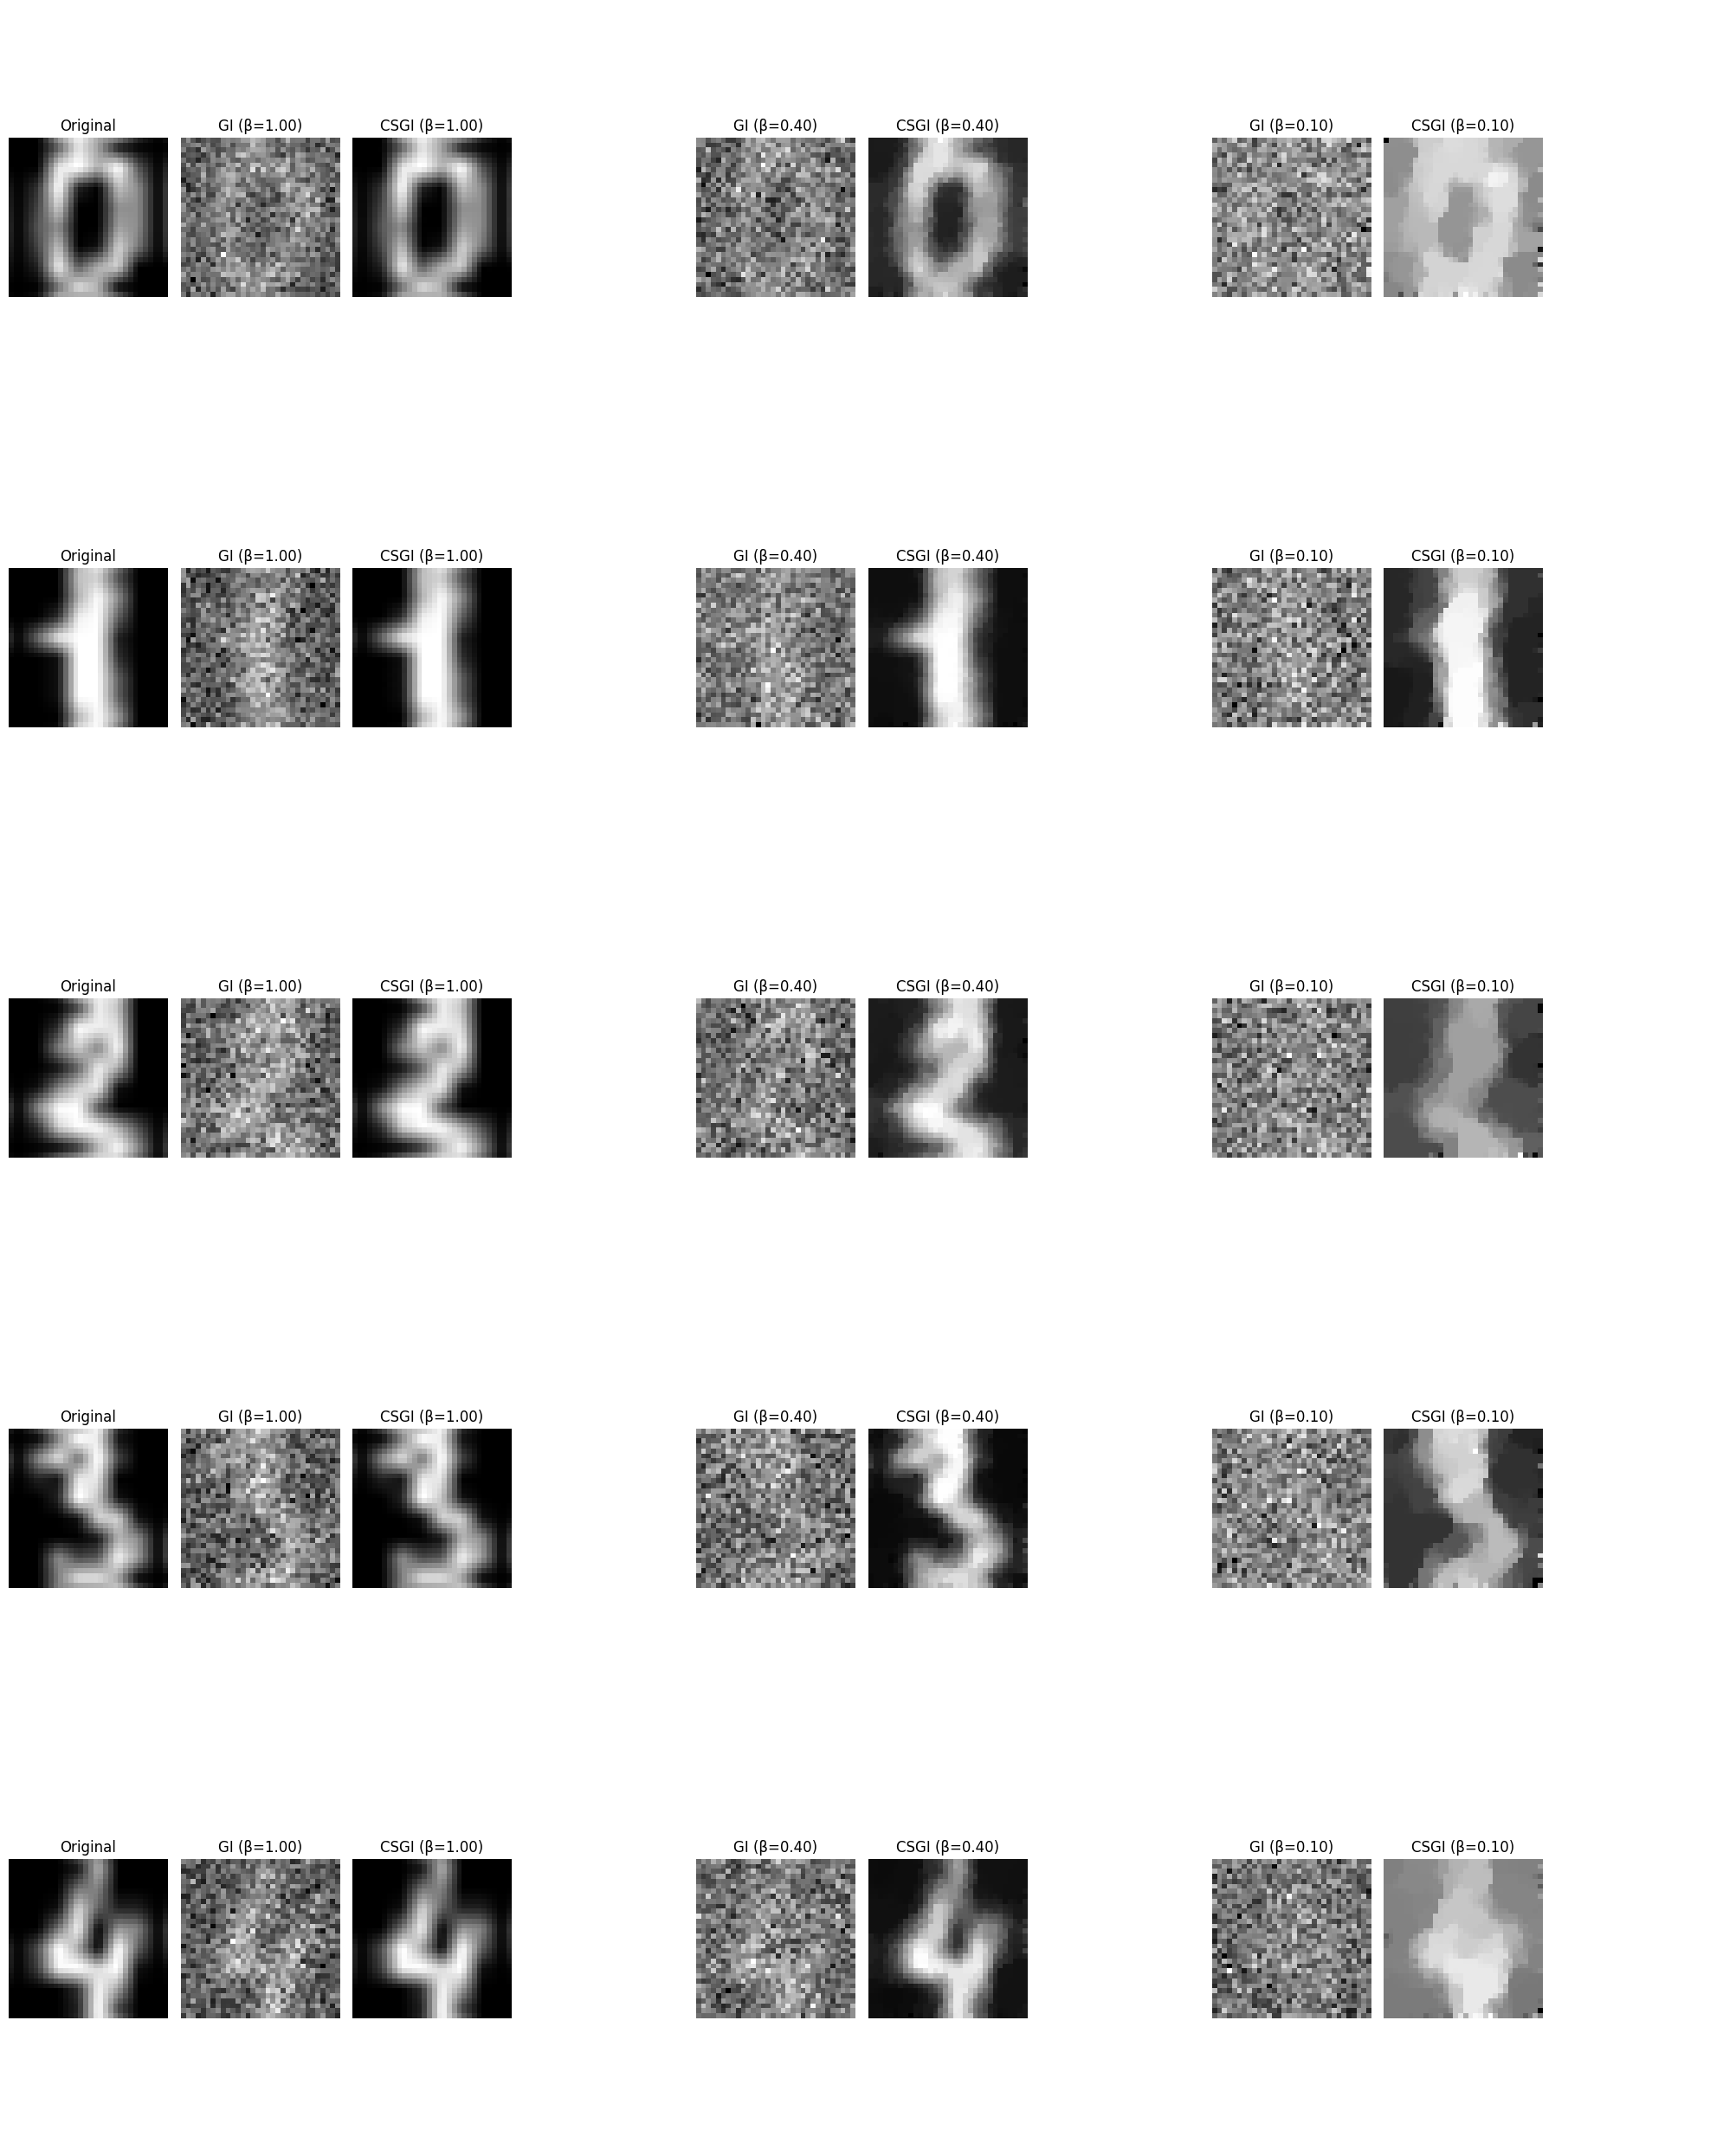

In [ ]:
# 预处理第三版
# 增多了几个样本，可视化好一点
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import cvxpy as cp
from skimage.restoration import denoise_tv_chambolle

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install cvxpy scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 数据准备
def prepare_data(num_images=5, image_size=32):
    # 加载MNIST数据集
    digits = load_digits()

    # 选择多个数字图像并调整大小
    images = []
    for i in range(num_images):
        image = digits.images[i]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)

    return images

# 生成随机speckle模式
def generate_speckle_patterns(num_patterns, image_size):
    return np.random.rand(num_patterns, image_size, image_size)

# 计算bucket信号
def calculate_bucket_signal(image, speckle_patterns):
    return np.sum(image * speckle_patterns, axis=(1, 2))

# 传统鬼影成像重构
def gi_reconstruction(bucket_signal, speckle_patterns):
    mean_bucket = np.mean(bucket_signal)
    mean_speckle = np.mean(speckle_patterns, axis=0)

    delta_bucket = bucket_signal - mean_bucket
    delta_speckle = speckle_patterns - mean_speckle

    reconstruction = np.mean(delta_bucket[:, np.newaxis, np.newaxis] * delta_speckle, axis=0)
    return reconstruction

# 压缩感知鬼影成像重构
def csgi_reconstruction(bucket_signal, speckle_patterns, lambda_tv):
    image_size = speckle_patterns.shape[1]
    num_patterns = speckle_patterns.shape[0]

    # 将speckle模式展平为矩阵A
    A = speckle_patterns.reshape(num_patterns, -1)

    # 定义优化问题
    x = cp.Variable(image_size * image_size)
    objective = cp.Minimize(cp.sum_squares(A @ x - bucket_signal) + lambda_tv * cp.tv(cp.reshape(x, (image_size, image_size))))
    prob = cp.Problem(objective)

    # 求解优化问题
    prob.solve()

    # 重塑结果为图像
    reconstruction = x.value.reshape(image_size, image_size)
    return reconstruction

# 可视化结果
def visualize_results(originals, gi_recons, csgi_recons, sampling_rates):
    num_images = len(originals)
    num_rates = len(sampling_rates)

    fig, axes = plt.subplots(num_images, 3 * num_rates + 1, figsize=(5 * num_rates + 5, 5 * num_images))

    for i, original in enumerate(originals):
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        for j, beta in enumerate(sampling_rates):
            axes[i, 3*j + 1].imshow(gi_recons[i][j], cmap='gray')
            axes[i, 3*j + 1].set_title(f'GI (β={beta:.2f})')
            axes[i, 3*j + 1].axis('off')

            axes[i, 3*j + 2].imshow(csgi_recons[i][j], cmap='gray')
            axes[i, 3*j + 2].set_title(f'CSGI (β={beta:.2f})')
            axes[i, 3*j + 2].axis('off')

            axes[i, 3*j + 3].axis('off')  # 空白列，用于分隔不同采样率的结果

    plt.tight_layout()
    plt.show()

# 主函数
def main():
    image_size = 32
    num_images = 5
    original_images = prepare_data(num_images, image_size)

    sampling_rates = [1.0, 0.4, 0.1]

    all_gi_recons = []
    all_csgi_recons = []

    for original_image in original_images:
        gi_recons = []
        csgi_recons = []

        for beta in sampling_rates:
            num_patterns = int(beta * image_size * image_size)
            speckle_patterns = generate_speckle_patterns(num_patterns, image_size)

            # 计算bucket信号
            bucket_signal = calculate_bucket_signal(original_image, speckle_patterns)

            # 传统GI重构
            gi_recon = gi_reconstruction(bucket_signal, speckle_patterns)
            gi_recons.append(gi_recon)

            # CSGI重构
            lambda_tv = 0.1  # 可以调整这个参数以获得更好的结果
            csgi_recon = csgi_reconstruction(bucket_signal, speckle_patterns, lambda_tv)
            csgi_recons.append(csgi_recon)

        all_gi_recons.append(gi_recons)
        all_csgi_recons.append(csgi_recons)

    # 可视化结果
    visualize_results(original_images, all_gi_recons, all_csgi_recons, sampling_rates)

if __name__ == "__main__":
    main()


In [ ]:
# 第一次GAN尝试，（CNN的尝试在其他地方）
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 数据准备
def prepare_data(num_images=1000, image_size=32):
    """
    从MNIST数据集加载并预处理手写数字图像
    """
    # 加载MNIST数据集
    digits = load_digits()

    # 选择多个数字图像并调整大小
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)

    # 归一化图像
    images = np.array(images)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))

    return images

# 生成初步重构图像（模拟传统GI结果）
def generate_initial_reconstructions(images, noise_level=0.3):
    """
    生成带有噪声的初步重构图像，模拟传统GI结果
    """
    noise = np.random.normal(0, noise_level, images.shape)
    initial_reconstructions = np.clip(images + noise, 0, 1)
    return initial_reconstructions

# 定义生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),

        # 编码器部分
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),

        # 解码器部分
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid')
    ])
    return model

# 定义判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# 定义GAN模型
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, initial_reconstructions = data

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            d_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                     self.loss_fn(tf.zeros_like(fake_output), fake_output)

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 训练GAN
def train_gan(gan, dataset, epochs=100, batch_size=32):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch in dataset.batch(batch_size):
            gan.train_step(batch)

        # 每10个epoch显示一次生成结果
        if (epoch + 1) % 10 == 0:
            display_results(gan, dataset, epoch + 1)

# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    initial_reconstructions = next(iter(dataset.batch(n)))[1]
    generated_images = gan.generator(initial_reconstructions, training=False)

    fig, axes = plt.subplots(3, n, figsize=(15, 9))
    for i in range(n):
        axes[0, i].imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Initial')

        axes[1, i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Generated')

        axes[2, i].imshow(next(iter(dataset.batch(n)))[0][i, :, :, 0], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('Original')

    plt.tight_layout()
    plt.savefig(f'gan_results_epoch_{epoch}.png')
    plt.close()

# 主函数
def main():
    # 准备数据
    images = prepare_data(num_images=1000)
    initial_reconstructions = generate_initial_reconstructions(images)

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((images[..., np.newaxis], initial_reconstructions[..., np.newaxis]))
    dataset = dataset.shuffle(buffer_size=1000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()
    gan = GAN(generator, discriminator)

    # 编译GAN模型
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy()
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=100, batch_size=32)

    # 显示最终结果
    display_results(gan, dataset, epoch=100)

if __name__ == "__main__":
    main()
#这个主要是发现问题（1）可视化处original图片对不上  （2）Epoch比较大的时候，图片质量好像下降了，过拟合

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

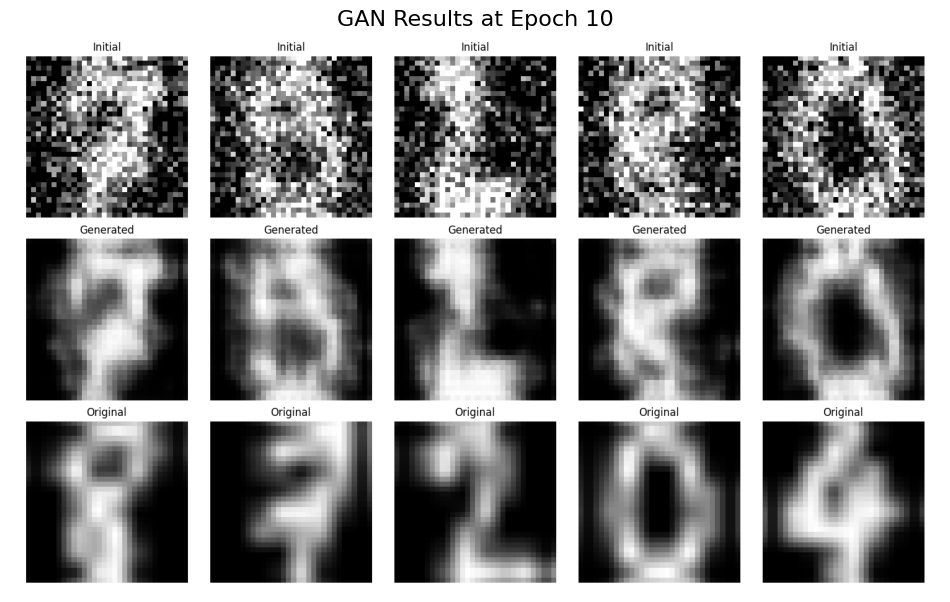

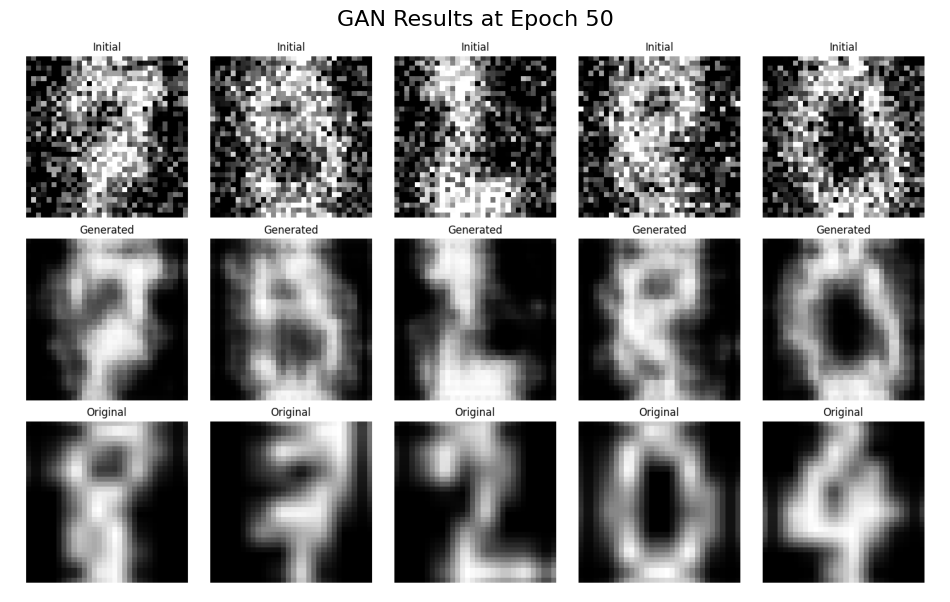

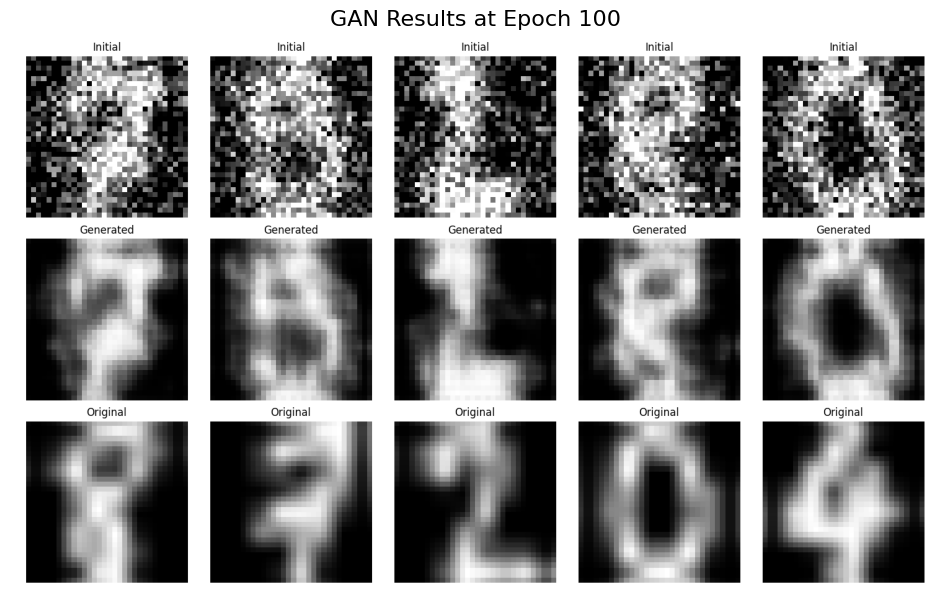

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 读取图像
image_path1 = '/content/gan_results_epoch_10.png'
image_path2 = '/content/gan_results_epoch_50.png'
image_path3 = '/content/gan_results_epoch_100.png'
img = Image.open(image_path1)

# 将图像转换为numpy数组
img_array = np.array(img)
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()
img = Image.open(image_path2)
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()
img = Image.open(image_path3)
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 100', fontsize=16)
plt.show()

In [12]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 数据准备
def prepare_data(num_images=5000, image_size=32):
    """
    从MNIST数据集加载并预处理手写数字图像
    """
    # 加载MNIST数据集
    digits = load_digits()

    # 选择多个数字图像并调整大小
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)

    # 归一化图像
    images = np.array(images)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))

    return images

# 生成初步重构图像（模拟传统GI结果）
def generate_initial_reconstructions(images, noise_level=0.3):
    """
    生成带有噪声的初步重构图像，模拟传统GI结果
    """
    noise = np.random.normal(0, noise_level, images.shape)
    initial_reconstructions = np.clip(images + noise, 0, 1)
    return initial_reconstructions

# 定义生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),

        # 编码器部分
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),

        # 解码器部分
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid')
    ])
    return model

# 定义判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# 定义GAN模型
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, initial_reconstructions = data

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            d_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                     self.loss_fn(tf.zeros_like(fake_output), fake_output)

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 训练GAN
def train_gan(gan, dataset, epochs=10, batch_size=32):
    g_losses = []
    d_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_g_losses = []
        epoch_d_losses = []
        for batch in dataset.batch(batch_size):
            losses = gan.train_step(batch)
            epoch_g_losses.append(losses['g_loss'].numpy())
            epoch_d_losses.append(losses['d_loss'].numpy())

        g_losses.append(np.mean(epoch_g_losses))
        d_losses.append(np.mean(epoch_d_losses))

        # 每10个epoch显示一次生成结果
        if (epoch + 1) % 1 == 0:
            display_results(gan, dataset, epoch + 1)

    # 绘制损失函数变化图
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Losses')
    plt.savefig('gan_losses.png')
    plt.close()

# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    sample = next(iter(dataset.batch(n)))
    original_images, initial_reconstructions = sample
    generated_images = gan.generator(initial_reconstructions, training=False)

    fig, axes = plt.subplots(3, n, figsize=(15, 9))
    for i in range(n):
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('GI')

        axes[2, i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('GIDL')

    plt.tight_layout()
    plt.savefig(f'GAN_results_epoch_{epoch}.png')
    plt.close()

# 主函数
def main():
    # 准备数据
    images = prepare_data(num_images=5000)
    initial_reconstructions = generate_initial_reconstructions(images)

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((images[..., np.newaxis], initial_reconstructions[..., np.newaxis]))
    dataset = dataset.shuffle(buffer_size=5000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()
    gan = GAN(generator, discriminator)

    # 编译GAN模型
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy()
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=10, batch_size=32)

    # 显示最终结果
    display_results(gan, dataset, epoch=10)

if __name__ == "__main__":
    main()


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


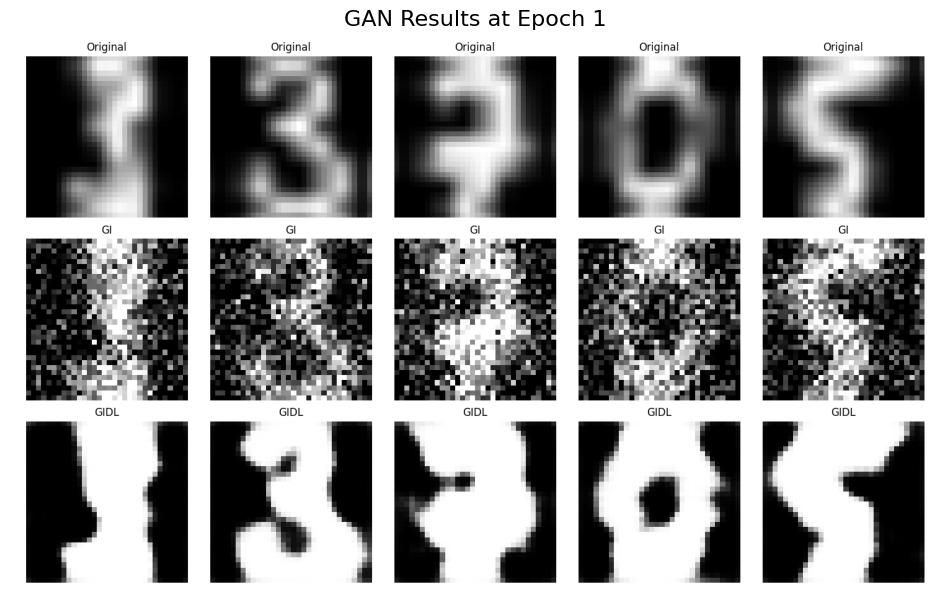

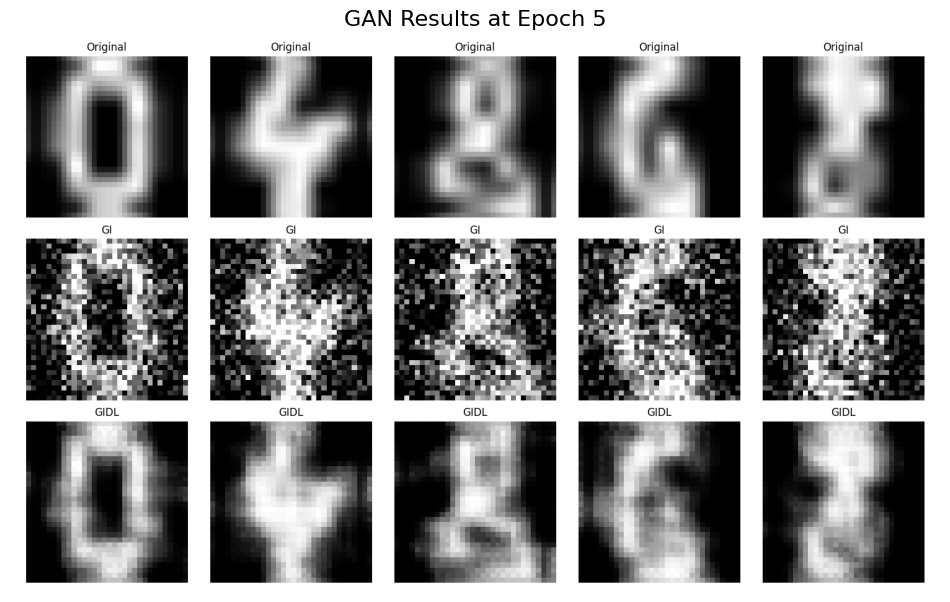

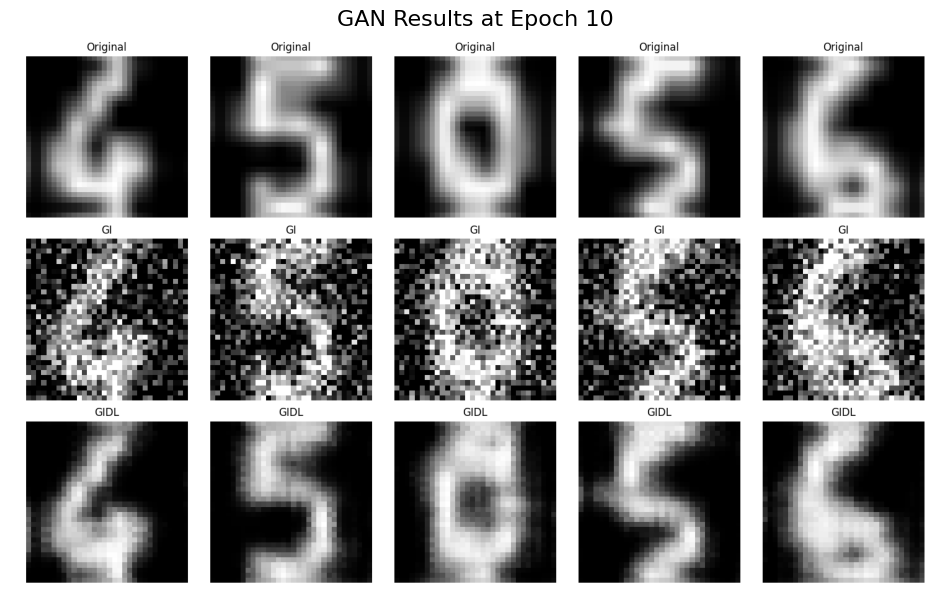

In [14]:
# 读取图像
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_path = '/content/GAN_results_epoch_1.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 1', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAN_results_epoch_5.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 5', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAN_results_epoch_10.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()

Here, nothing else has been changed. It's just that the gpu runs the code, and the A100 is used

In [ ]:

# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 检查是否有可用的GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# 如果有GPU，设置内存增长
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 安装所需的库（如果在Colab环境中尚未安装）
!pip install scikit-image

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 数据准备函数
def prepare_data(num_images=5000, image_size=32):
    digits = load_digits()
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)
    images = np.array(images)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    return images

# 生成初步重构图像函数
def generate_initial_reconstructions(images, noise_level=0.3):
    noise = np.random.normal(0, noise_level, images.shape)
    initial_reconstructions = np.clip(images + noise, 0, 1)
    return initial_reconstructions

# 生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='tanh')
    ])
    return model

# 判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# GAN模型
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, initial_reconstructions = data
        batch_size = tf.shape(real_images)[0]

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = real_loss + fake_loss

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 训练GAN
def train_gan(gan, dataset, epochs=10, batch_size=32):
    g_losses = []
    d_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_g_losses = []
        epoch_d_losses = []
        for batch in dataset.batch(batch_size):
            losses = gan.train_step(batch)
            epoch_g_losses.append(losses['g_loss'].numpy())
            epoch_d_losses.append(losses['d_loss'].numpy())

        g_losses.append(np.mean(epoch_g_losses))
        d_losses.append(np.mean(epoch_d_losses))

        print(f"G Loss: {g_losses[-1]:.4f}, D Loss: {d_losses[-1]:.4f}")

        # 每个epoch显示一次生成结果
        display_results(gan, dataset, epoch + 1)

    # 绘制损失函数变化图
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Losses')
    plt.savefig('gan_losses.png')
    plt.close()

# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    sample = next(iter(dataset.batch(n)))
    original_images, initial_reconstructions = sample
    generated_images = gan.generator(initial_reconstructions, training=False)

    fig, axes = plt.subplots(3, n, figsize=(15, 9))
    for i in range(n):
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('GI')

        axes[2, i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('GIDL')

    plt.tight_layout()
    plt.savefig(f'gan3_results_epoch_{epoch}.png')
    plt.close()

# 主函数
def main():
    # 准备数据
    images = prepare_data(num_images=5000)
    initial_reconstructions = generate_initial_reconstructions(images)

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((images[..., np.newaxis], initial_reconstructions[..., np.newaxis]))
    dataset = dataset.shuffle(buffer_size=5000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()
    gan = GAN(generator, discriminator)

    # 编译GAN模型
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=10, batch_size=32)

    # 显示最终结果
    display_results(gan, dataset, epoch=10)

if __name__ == "__main__":
    main()


Num GPUs Available:  1
Physical devices cannot be modified after being initialized
Epoch 1/10
G Loss: 1.0713, D Loss: 0.9488
Epoch 2/10
G Loss: 1.0458, D Loss: 1.0526
Epoch 3/10
G Loss: 1.0939, D Loss: 1.0049
Epoch 4/10
G Loss: 1.1696, D Loss: 0.9246
Epoch 5/10
G Loss: 1.2135, D Loss: 0.8852
Epoch 6/10
G Loss: 1.2860, D Loss: 0.8226
Epoch 7/10
G Loss: 1.4011, D Loss: 0.7539
Epoch 8/10
G Loss: 1.4910, D Loss: 0.6905
Epoch 9/10
G Loss: 1.6087, D Loss: 0.6246
Epoch 10/10
G Loss: 1.7417, D Loss: 0.5631


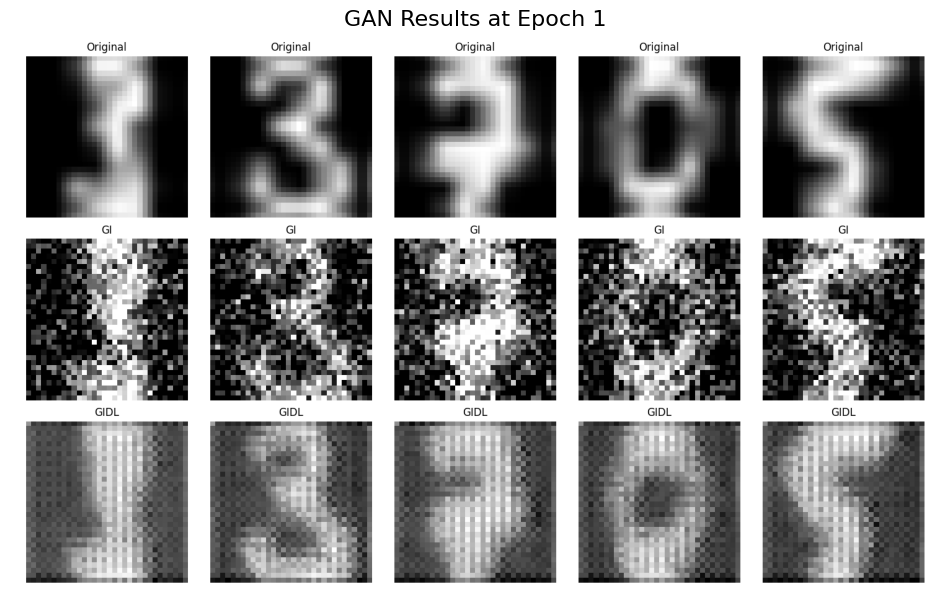

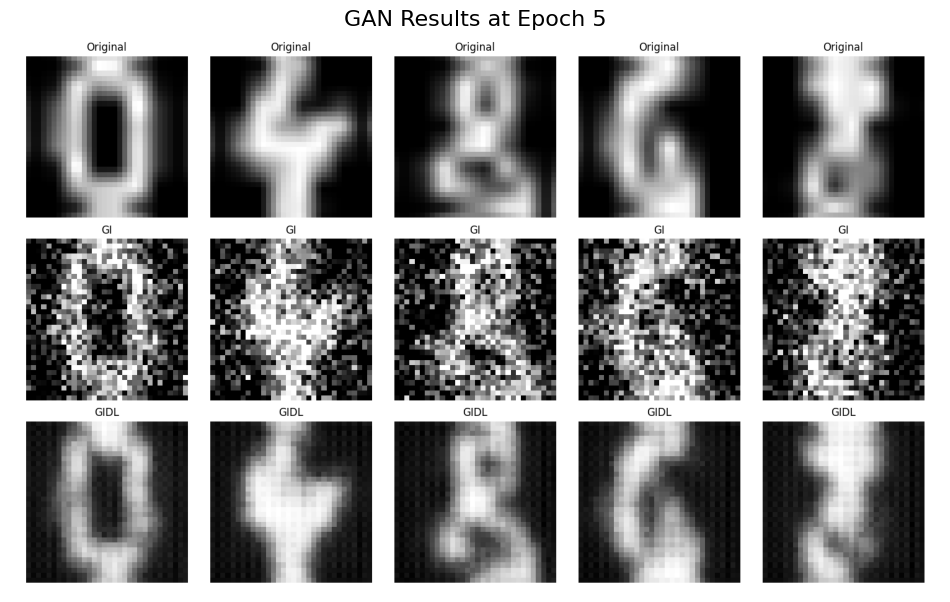

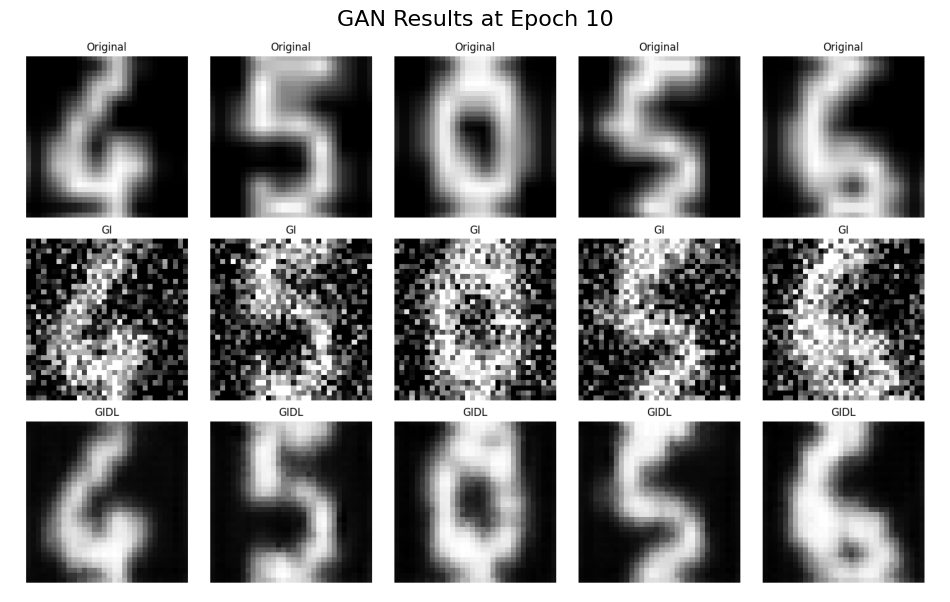

In [ ]:
# 读取图像
image_path = '/content/gan3_results_epoch_1.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 1', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/gan3_results_epoch_5.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 5', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/gan3_results_epoch_10.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()

Third version
 Try to evaluate image quality using PSNR,SSIM and MSE

In [24]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 数据准备
def prepare_data(num_images=5000, image_size=32):
    """
    从MNIST数据集加载并预处理手写数字图像
    """
    digits = load_digits()
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)
    images = np.array(images, dtype=np.float32)  # 确保数据类型为 float32
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    return images
def generate_initial_reconstructions(images, noise_level=0.3):
    """
    生成带有噪声的初步重构图像，模拟传统GI结果
    """
    noise = np.random.normal(0, noise_level, images.shape).astype(np.float32)  # 确保噪声类型为 float32
    initial_reconstructions = np.clip(images + noise, 0, 1)
    return initial_reconstructions

# 修改生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='tanh')
    ])
    return model

# 修改判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# 定义评估指标
class EvaluationMetrics:
    @staticmethod
    def calculate_psnr(original, generated):
        return psnr(original, generated, data_range=1.0)

    @staticmethod
    def calculate_ssim(original, generated):
        return ssim(original, generated, data_range=1.0)

    @staticmethod
    def calculate_mse(original, generated):
        return mean_squared_error(original.flatten(), generated.flatten())

    @staticmethod
    def evaluate_batch(original_batch, generated_batch):
        batch_psnr = []
        batch_ssim = []
        batch_mse = []

        for orig, gen in zip(original_batch, generated_batch):
            if orig.ndim == 3:
                orig = orig.squeeze()
            if gen.ndim == 3:
                gen = gen.squeeze()

            batch_psnr.append(EvaluationMetrics.calculate_psnr(orig, gen))
            batch_ssim.append(EvaluationMetrics.calculate_ssim(orig, gen))
            batch_mse.append(EvaluationMetrics.calculate_mse(orig, gen))

        return {
            'psnr': np.mean(batch_psnr),
            'ssim': np.mean(batch_ssim),
            'mse': np.mean(batch_mse)
        }

# 定义GAN模型
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.metrics_tracker = {
            'psnr': [], 'ssim': [], 'mse': [],
            'g_loss': [], 'd_loss': []
        }

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, data):
        real_images, initial_reconstructions = data

        # 确保输入数据类型为 float32
        real_images = tf.cast(real_images, tf.float32)
        initial_reconstructions = tf.cast(initial_reconstructions, tf.float32)

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = real_loss + fake_loss

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        # 计算评估指标
        psnr = tf.image.psnr(real_images, fake_images, max_val=1.0)
        ssim = tf.image.ssim(real_images, fake_images, max_val=1.0)
        mse = tf.reduce_mean(tf.square(real_images - fake_images))

        return {
            "d_loss": d_loss,
            "g_loss": g_loss,
            "psnr": tf.reduce_mean(psnr),
            "ssim": tf.reduce_mean(ssim),
            "mse": mse
        }

# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    sample = next(iter(dataset.batch(n)))
    original_images, initial_reconstructions = sample
    generated_images = gan.generator(initial_reconstructions, training=False)

    plt.figure(figsize=(15, 9))
    for i in range(n):
        # Original images
        plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Initial reconstructions
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Initial')

        # Generated images
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Generated')

    plt.tight_layout()
    plt.savefig(f'gan_results_epoch_{epoch}.png')
    plt.close()

# 绘制评估指标
def plot_metrics(metrics_tracker):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].plot(metrics_tracker['g_loss'], label='Generator Loss')
    axes[0, 0].plot(metrics_tracker['d_loss'], label='Discriminator Loss')
    axes[0, 0].set_title('Training Losses')
    axes[0, 0].legend()

    axes[0, 1].plot(metrics_tracker['psnr'])
    axes[0, 1].set_title('PSNR')

    axes[1, 0].plot(metrics_tracker['ssim'])
    axes[1, 0].set_title('SSIM')

    axes[1, 1].plot(metrics_tracker['mse'])
    axes[1, 1].set_title('MSE')

    plt.tight_layout()
    plt.savefig('gan_metrics.png')
    plt.close()

# 训练GAN
def train_gan(gan, dataset, epochs=100, batch_size=32):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        epoch_metrics = {
            'g_loss': [], 'd_loss': [],
            'psnr': [], 'ssim': [], 'mse': []
        }

        for batch in dataset.batch(batch_size):
            metrics = gan.train_step(batch)

            for key in epoch_metrics.keys():
                epoch_metrics[key].append(float(metrics[key]))

        # 计算每个epoch的平均值
        epoch_averages = {
            key: np.mean(values) for key, values in epoch_metrics.items()
        }

        # 存储指标
        for key, value in epoch_averages.items():
            gan.metrics_tracker[key].append(value)

        print(f"G Loss: {epoch_averages['g_loss']:.4f}, "
              f"D Loss: {epoch_averages['d_loss']:.4f}, "
              f"PSNR: {epoch_averages['psnr']:.2f}, "
              f"SSIM: {epoch_averages['ssim']:.4f}, "
              f"MSE: {epoch_averages['mse']:.6f}")

        if (epoch + 1) % 10 == 0:  # 每10个epoch显示一次结果
            display_results(gan, dataset, epoch + 1)

    # 绘制最终指标
    plot_metrics(gan.metrics_tracker)

# 主函数
def main():
    # 准备数据
    images = prepare_data(num_images=5000)
    initial_reconstructions = generate_initial_reconstructions(images)

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((
        images[..., np.newaxis],
        initial_reconstructions[..., np.newaxis]
    ))
    dataset = dataset.shuffle(buffer_size=5000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()

    # 创建并编译GAN
    gan = GAN(generator, discriminator)
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=50, batch_size=32)

if __name__ == "__main__":
    main()


Epoch 1/50
G Loss: 1.5803, D Loss: 0.6798, PSNR: 9.91, SSIM: 0.3297, MSE: 0.176805
Epoch 2/50
G Loss: 1.5641, D Loss: 0.7383, PSNR: 19.29, SSIM: 0.7206, MSE: 0.012119
Epoch 3/50
G Loss: 1.7951, D Loss: 0.6910, PSNR: 20.30, SSIM: 0.7623, MSE: 0.009557
Epoch 4/50
G Loss: 2.0678, D Loss: 0.6330, PSNR: 20.69, SSIM: 0.7775, MSE: 0.008763
Epoch 5/50
G Loss: 2.3188, D Loss: 0.5935, PSNR: 20.96, SSIM: 0.7866, MSE: 0.008244
Epoch 6/50
G Loss: 2.6860, D Loss: 0.5291, PSNR: 21.24, SSIM: 0.7936, MSE: 0.007721
Epoch 7/50
G Loss: 2.7039, D Loss: 0.4951, PSNR: 21.48, SSIM: 0.8024, MSE: 0.007320
Epoch 8/50
G Loss: 2.9188, D Loss: 0.4353, PSNR: 21.74, SSIM: 0.8083, MSE: 0.006893
Epoch 9/50
G Loss: 3.5481, D Loss: 0.4020, PSNR: 21.89, SSIM: 0.8132, MSE: 0.006673
Epoch 10/50
G Loss: 3.7872, D Loss: 0.3667, PSNR: 22.10, SSIM: 0.8210, MSE: 0.006354
Epoch 11/50
G Loss: 3.9685, D Loss: 0.3557, PSNR: 22.23, SSIM: 0.8269, MSE: 0.006160
Epoch 12/50
G Loss: 3.9968, D Loss: 0.3074, PSNR: 22.12, SSIM: 0.8283, MSE:

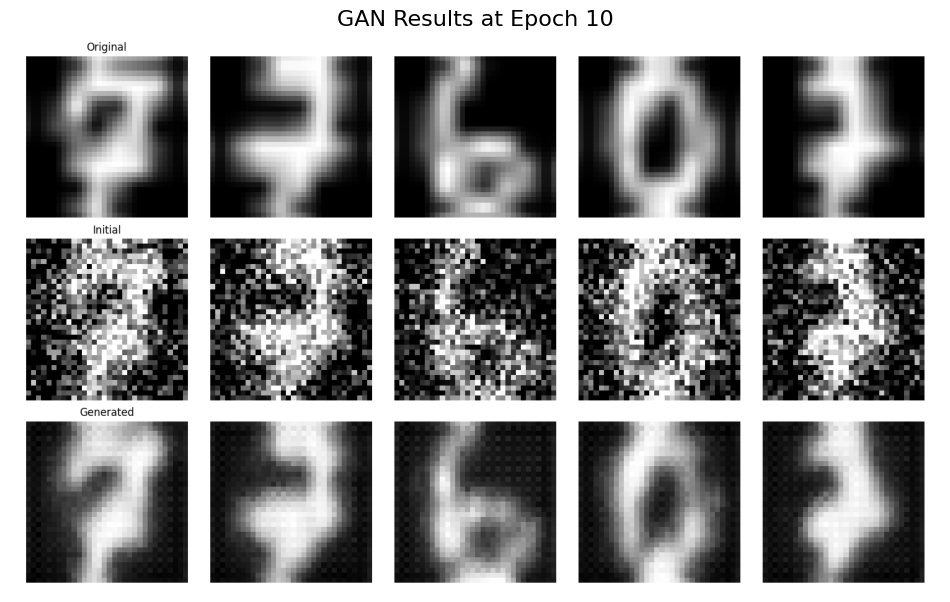

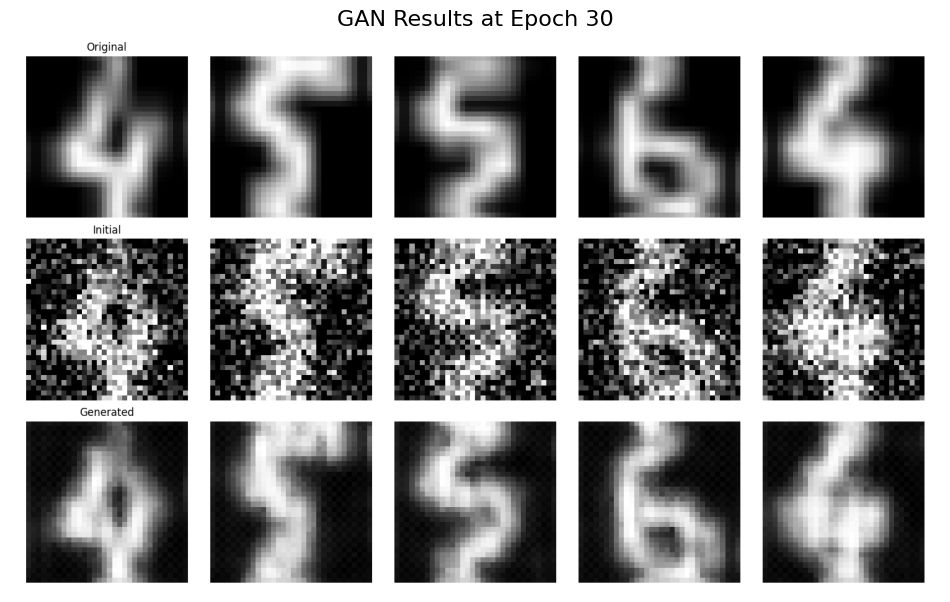

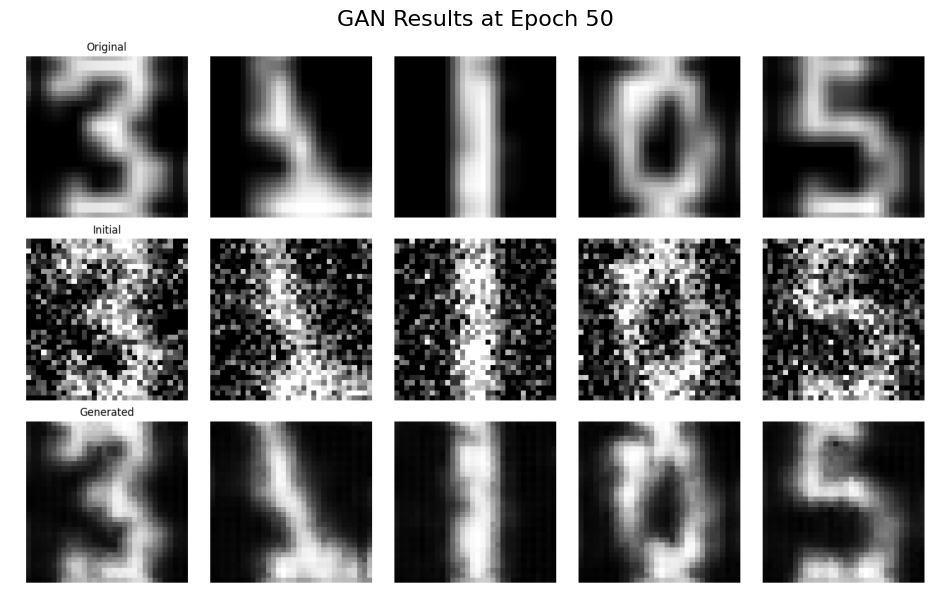

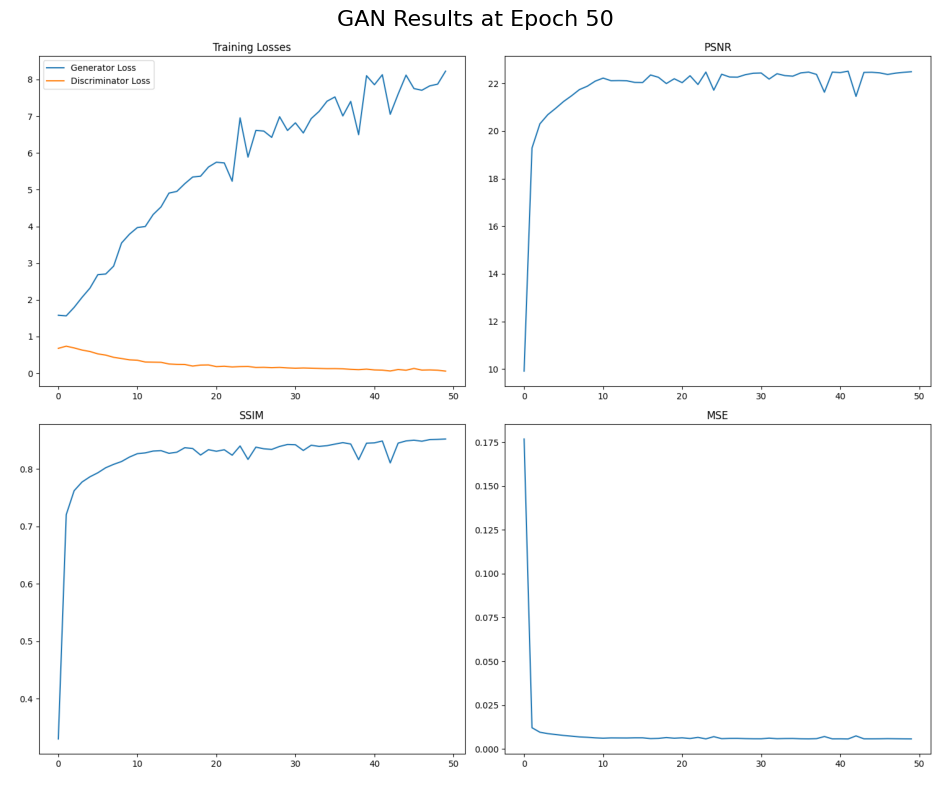

In [25]:
# 读取图像
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_path = '/content/gan_results_epoch_10.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/gan_results_epoch_30.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 30', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/gan_results_epoch_50.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()

image_path = '/content/gan_metrics.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()

Fourth version

There are two attempts in the subsequent code
1. Try to use traditional GI for data instead of simply simulating with noise

2. Separate data preparation from GAN training to facilitate parameter adjustment

In [19]:
import tensorflow as tf

# GPU配置
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np
from sklearn.datasets import load_digits
from skimage.transform import resize

# 设置随机种子
np.random.seed(42)
tf.random.set_seed(42)

def prepare_data(num_images=5000, image_size=32):
    """从MNIST数据集加载并预处理手写数字图像"""
    digits = load_digits()
    images = []
    for i in range(num_images):
        image = digits.images[i % len(digits.images)]
        image = resize(image, (image_size, image_size), anti_aliasing=True)
        images.append(image)
    images = np.array(images, dtype=np.float32)
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    return images

def generate_speckle_patterns(num_patterns, image_size):
    """生成随机光斑模式"""
    return np.random.rand(num_patterns, image_size, image_size)

def calculate_bucket_signal(image, speckle_patterns):
    """计算bucket信号"""
    return np.sum(image * speckle_patterns, axis=(1, 2))

def gi_reconstruction(bucket_signal, speckle_patterns):
    """传统鬼影成像重构"""
    mean_bucket = np.mean(bucket_signal)
    mean_speckle = np.mean(speckle_patterns, axis=0)

    delta_bucket = bucket_signal - mean_bucket
    delta_speckle = speckle_patterns - mean_speckle

    reconstruction = np.mean(delta_bucket[:, np.newaxis, np.newaxis] * delta_speckle, axis=0)
    return reconstruction

def generate_initial_reconstructions(images, noise_level=0.3):
    """使用传统鬼影成像方法生成带有噪声的初步重构图像"""
    # 处理输入维度
    if images.ndim == 2:
        images = np.expand_dims(np.expand_dims(images, 0), -1)
    elif images.ndim == 3:
        if images.shape[2] <= 4:
            images = np.expand_dims(images, 0)
        else:
            images = np.expand_dims(images, -1)

    num_images, height, width, channels = images.shape

    # 计算测量次数和beta值
    num_measurements = int(1000 * (1 - noise_level))
    beta = num_measurements / (height * width)

    reconstructions = np.zeros_like(images)

    for i in range(num_images):
        image = images[i, ..., 0]  # 取单通道

        # 生成光斑模式
        speckle_patterns = generate_speckle_patterns(num_measurements, height)

        # 计算bucket信号
        bucket_signal = calculate_bucket_signal(image, speckle_patterns)

        # 进行GI重构
        reconstruction = gi_reconstruction(bucket_signal, speckle_patterns)

        # 归一化
        reconstruction = (reconstruction - np.min(reconstruction)) / (np.max(reconstruction) - np.min(reconstruction))

        reconstructions[i, ..., 0] = reconstruction

    # 添加噪声
    noise = np.random.normal(0, noise_level/2, reconstructions.shape)
    reconstructions = np.clip(reconstructions + noise, 0, 1)

    # 恢复原始维度
    if images.shape[1] == 2:
        reconstructions = np.squeeze(reconstructions)
    elif images.shape[1] == 3:
        if channels == 1:
            reconstructions = np.squeeze(reconstructions, axis=-1)

    return reconstructions

    # 准备数据
images = prepare_data(num_images=5000)
    # 生成重构图像
initial_reconstructions = generate_initial_reconstructions(images)


Physical devices cannot be modified after being initialized


In [36]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)


# 修改生成器模型
def build_generator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='tanh')
    ])
    return model

# 修改判别器模型
def build_discriminator(input_shape=(32, 32, 1)):
    model = keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# 定义评估指标
class EvaluationMetrics:
    @staticmethod
    def calculate_psnr(original, generated):
        return psnr(original, generated, data_range=1.0)

    @staticmethod
    def calculate_ssim(original, generated):
        return ssim(original, generated, data_range=1.0)

    @staticmethod
    def calculate_mse(original, generated):
        return mean_squared_error(original.flatten(), generated.flatten())

    @staticmethod
    def evaluate_batch(original_batch, generated_batch):
        batch_psnr = []
        batch_ssim = []
        batch_mse = []

        for orig, gen in zip(original_batch, generated_batch):
            if orig.ndim == 3:
                orig = orig.squeeze()
            if gen.ndim == 3:
                gen = gen.squeeze()

            batch_psnr.append(EvaluationMetrics.calculate_psnr(orig, gen))
            batch_ssim.append(EvaluationMetrics.calculate_ssim(orig, gen))
            batch_mse.append(EvaluationMetrics.calculate_mse(orig, gen))

        return {
            'psnr': np.mean(batch_psnr),
            'ssim': np.mean(batch_ssim),
            'mse': np.mean(batch_mse)
        }

class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.metrics_tracker = {
            'psnr': [], 'ssim': [], 'mse': [],
            'g_loss': [], 'd_loss': []
        }

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn


    @tf.function
    def train_step(self, data):
        real_images, initial_reconstructions = data
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=tf.shape(real_images), mean=0.0, stddev=0.12)

        # 添加噪声到真实和生成的图像
        noisy_real = real_images + noise
        fake_images = self.generator(initial_reconstructions, training=True)
        noisy_fake = fake_images + noise

        # 确保输入数据类型为 float32
        noisy_real = tf.cast(noisy_real, tf.float32)
        initial_reconstructions = tf.cast(initial_reconstructions, tf.float32)

        # 训练判别器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            real_output = self.discriminator(noisy_real, training=True)
            fake_output = self.discriminator(noisy_fake, training=True)

            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = real_loss + fake_loss

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # 训练生成器
        with tf.GradientTape() as tape:
            fake_images = self.generator(initial_reconstructions, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        # 计算评估指标
        psnr = tf.image.psnr(real_images, fake_images, max_val=1.0)
        ssim = tf.image.ssim(real_images, fake_images, max_val=1.0)
        mse = tf.reduce_mean(tf.square(real_images - fake_images))

        return {
            "d_loss": d_loss,
            "g_loss": g_loss,
            "psnr": tf.reduce_mean(psnr),
            "ssim": tf.reduce_mean(ssim),
            "mse": mse
        }
# 显示结果
def display_results(gan, dataset, epoch):
    n = 5
    sample = next(iter(dataset.batch(n)))
    original_images, initial_reconstructions = sample
    generated_images = gan.generator(initial_reconstructions, training=False)

    plt.figure(figsize=(15, 9))
    for i in range(n):
        # Original images
        plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Initial reconstructions
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(initial_reconstructions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Initial')

        # Generated images
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Generated')

    plt.tight_layout()
    plt.savefig(f'GAM_results_epoch_{epoch}.png')
    plt.close()

# 绘制评估指标
def plot_metrics(metrics_tracker):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].plot(metrics_tracker['g_loss'], label='Generator Loss')
    axes[0, 0].plot(metrics_tracker['d_loss'], label='Discriminator Loss')
    axes[0, 0].set_title('Training Losses')
    axes[0, 0].legend()

    axes[0, 1].plot(metrics_tracker['psnr'])
    axes[0, 1].set_title('PSNR')

    axes[1, 0].plot(metrics_tracker['ssim'])
    axes[1, 0].set_title('SSIM')

    axes[1, 1].plot(metrics_tracker['mse'])
    axes[1, 1].set_title('MSE')

    plt.tight_layout()
    plt.savefig('gan_metrics.png')
    plt.close()

# 训练GAN
def train_gan(gan, dataset, epochs=20, batch_size=32):

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        epoch_metrics = {
            'g_loss': [], 'd_loss': [],
            'psnr': [], 'ssim': [], 'mse': []
        }

        for batch in dataset.batch(batch_size):
            metrics = gan.train_step(batch)

            for key in epoch_metrics.keys():
                epoch_metrics[key].append(metrics[key].numpy())

        # 计算每个epoch的平均值
        epoch_averages = {
            key: np.mean(values) for key, values in epoch_metrics.items()
        }

        # 存储指标
        for key, value in epoch_averages.items():
            gan.metrics_tracker[key].append(value)

        print(f"G Loss: {epoch_averages['g_loss']:.4f}, "
              f"D Loss: {epoch_averages['d_loss']:.4f}, "
              f"PSNR: {epoch_averages['psnr']:.2f}, "
              f"SSIM: {epoch_averages['ssim']:.4f}, "
              f"MSE: {epoch_averages['mse']:.6f}")

        if (epoch + 1) % 10 == 0:  # 每10个epoch显示一次结果
            display_results(gan, dataset, epoch + 1)

    # 绘制最终指标
    plot_metrics(gan.metrics_tracker)

# 主函数
def main():

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((
        images[..., np.newaxis],
        initial_reconstructions[..., np.newaxis]
    ))
    dataset = dataset.shuffle(buffer_size=5000)

    # 构建GAN模型
    generator = build_generator()
    discriminator = build_discriminator()

    # 创建并编译GAN
    gan = GAN(generator, discriminator)
    gan.compile(
        g_optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.1),
        d_optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.1),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
    )

    # 训练GAN
    train_gan(gan, dataset, epochs=160, batch_size=32)

if __name__ == "__main__":
    main()



Epoch 1/160
G Loss: 0.7238, D Loss: 1.3015, PSNR: 1.83, SSIM: 0.0062, MSE: 0.661740
Epoch 2/160
G Loss: 0.8271, D Loss: 1.1581, PSNR: 3.43, SSIM: 0.0710, MSE: 0.460045
Epoch 3/160
G Loss: 0.9399, D Loss: 1.0796, PSNR: 4.59, SSIM: 0.1021, MSE: 0.351952
Epoch 4/160
G Loss: 0.9769, D Loss: 1.0671, PSNR: 5.85, SSIM: 0.1439, MSE: 0.261981
Epoch 5/160
G Loss: 1.0524, D Loss: 1.0131, PSNR: 7.24, SSIM: 0.2792, MSE: 0.190701
Epoch 6/160
G Loss: 1.0513, D Loss: 0.9706, PSNR: 8.40, SSIM: 0.3644, MSE: 0.146960
Epoch 7/160
G Loss: 1.0408, D Loss: 0.9213, PSNR: 9.32, SSIM: 0.4149, MSE: 0.119469
Epoch 8/160
G Loss: 0.9822, D Loss: 0.9079, PSNR: 10.19, SSIM: 0.4464, MSE: 0.098641
Epoch 9/160
G Loss: 0.8818, D Loss: 0.9520, PSNR: 10.87, SSIM: 0.4688, MSE: 0.084685
Epoch 10/160
G Loss: 0.9379, D Loss: 0.8401, PSNR: 11.39, SSIM: 0.4907, MSE: 0.075724
Epoch 11/160
G Loss: 0.5589, D Loss: 1.2969, PSNR: 12.79, SSIM: 0.4613, MSE: 0.056838
Epoch 12/160
G Loss: 0.5256, D Loss: 1.3283, PSNR: 13.56, SSIM: 0.5064

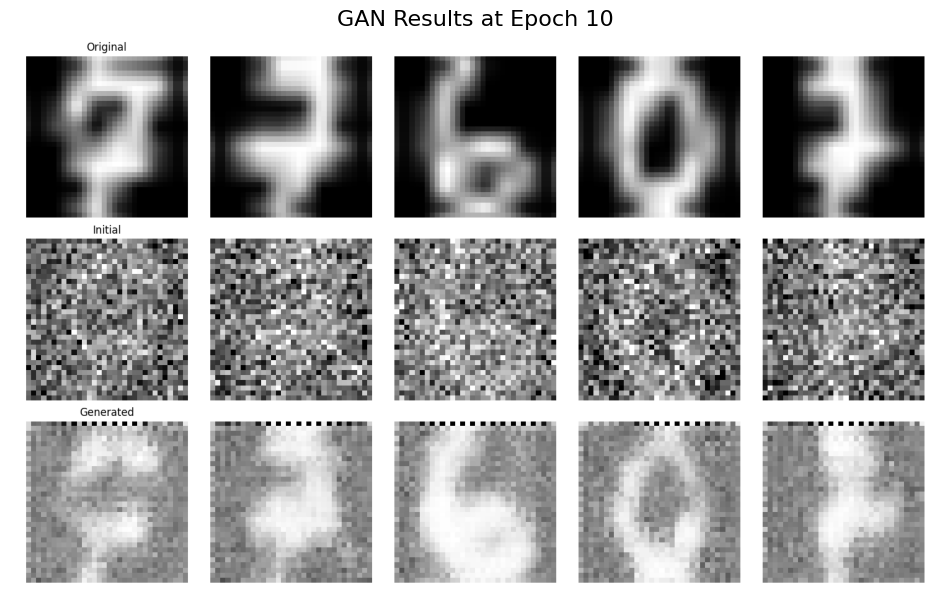

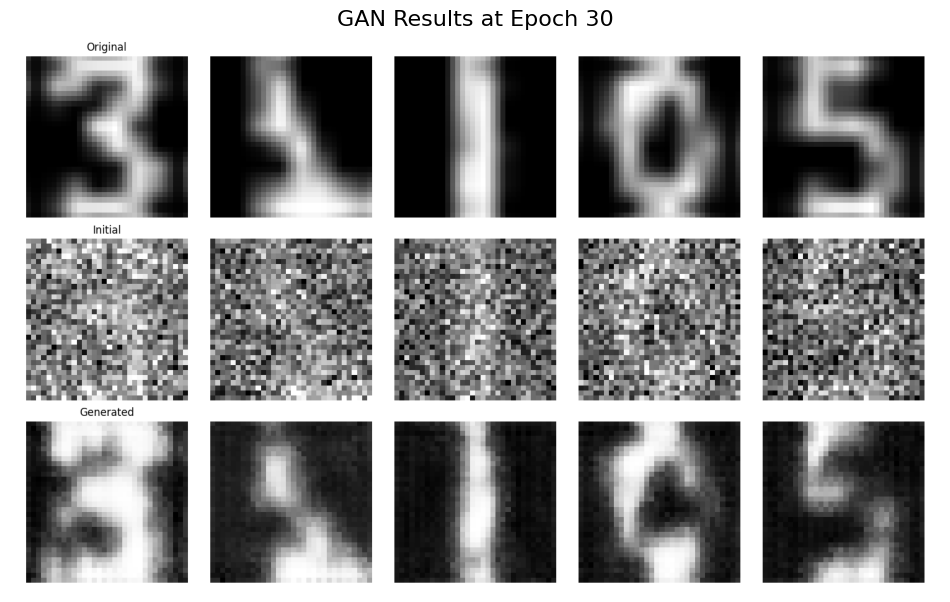

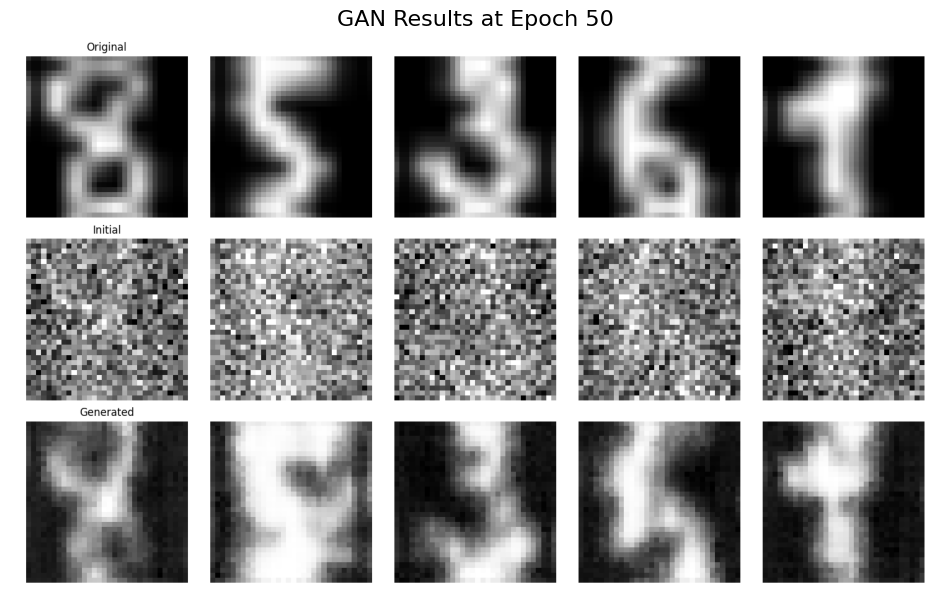

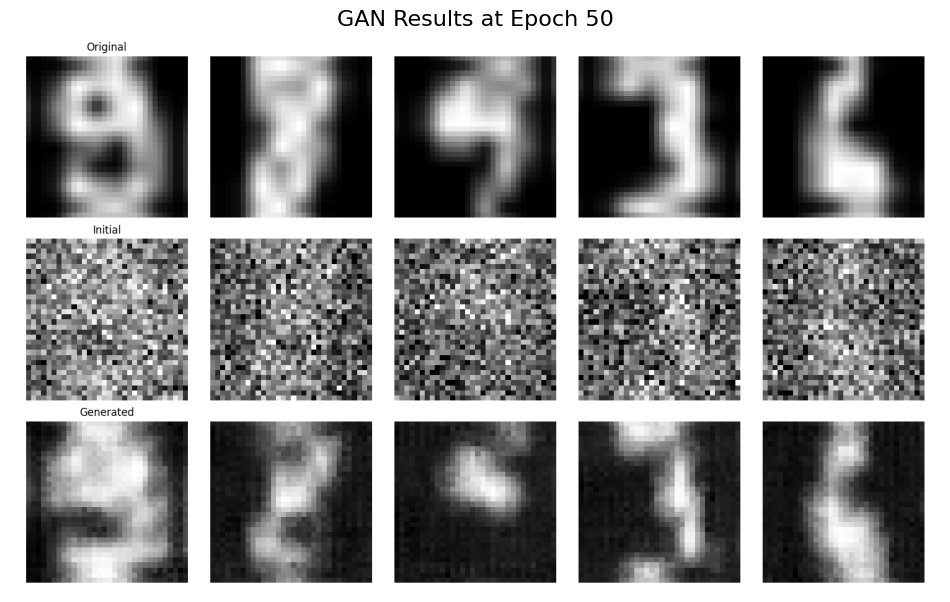

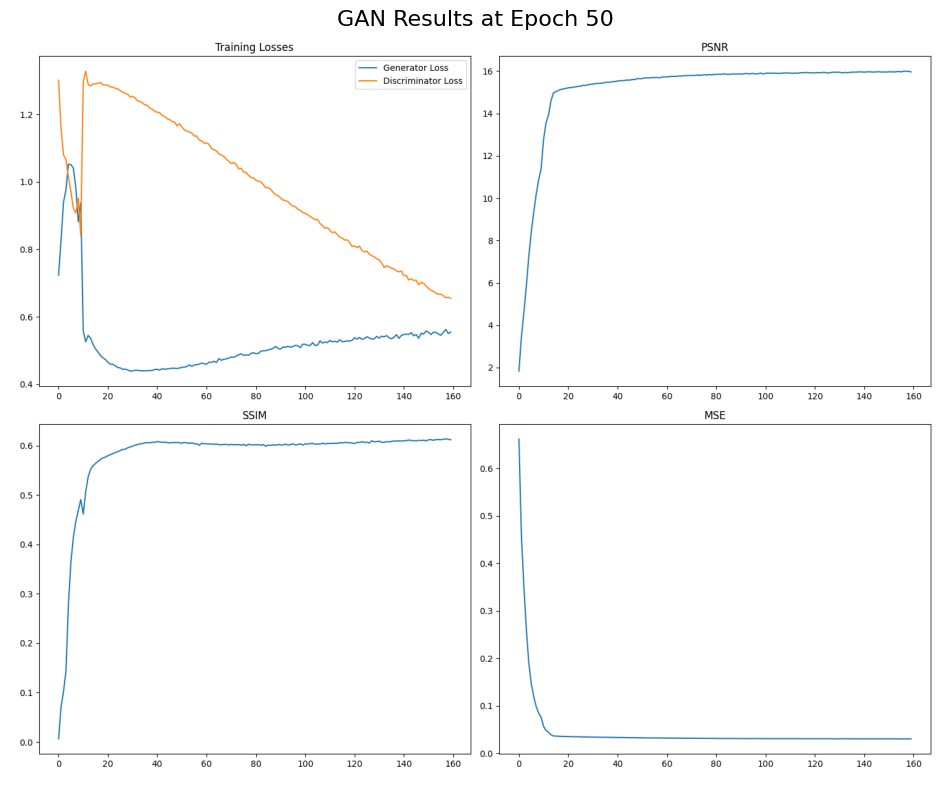

In [40]:
# 读取图像
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_path = '/content/GAM_results_epoch_10.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 10', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAM_results_epoch_50.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 30', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAM_results_epoch_100.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()

# 读取图像
image_path = '/content/GAM_results_epoch_150.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()

image_path = '/content/gan_metrics.png'
img = Image.open(image_path)

# 将图像转换为numpy数组
img_array = np.array(img)

# 显示图像
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.title('GAN Results at Epoch 50', fontsize=16)
plt.show()